In [1]:
import os
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm # Not necessary to install - just does loading bars
from yahooquery import Ticker
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

TRADING_DAYS = 252
SMALL, MED, LARGE = 18, 24, 30
LW = 2
plt.rc('xtick',labelsize=SMALL)
plt.rc('ytick',labelsize=SMALL)

# Modern Portfolio Theory

Before we can do any optimisation, we need to load the data.

In [112]:
# Get a list of all etfs and shares
shares = pd.read_csv('Shares.csv').Code.unique() # Shares.csv was downloaded from asx site
etfs = pd.read_csv('ETFs.csv')['ASX Code'].unique() # ETFs.csv was copy-pasted into excel from asx table
all_codes = sorted(set([code for code in list(shares) + list(etfs) if code is not np.nan]))
all_codes

# Try loading a dataframe of all daily data since start date for each asx code
START = '2013-01-01'
MIN_AUD_DAILY_LIQUIDITY = 100_000
try:
    daily = pd.read_csv('daily.csv')
    print('Successfully loaded daily.csv')
    
# If there is no daily.csv, it will generate and save it
except:
    not_found = []
    illiquid = []
    daily = pd.DataFrame({'date': []})

    for code in tqdm(all_codes):
        try:
            df = Ticker(f'{code}.AX').history(start=START).reset_index()
            
            latest = df.iloc[-1]
            # Exclude illiquid assets
            if latest.volume * latest.low < MIN_AUD_DAILY_LIQUIDITY:
                illiquid.append(code)
                continue
            df = df[['date', 'adjclose']]
            df.columns = ['date', code]
            daily = pd.merge(daily, df, on='date', how='outer').sort_values('date')
        except:
            not_found.append(code)

    daily.to_csv('daily.csv', index=False)
    
    print('History not found for:', end=' ')
    for code in not_found:
        print(code, end=' ')
    print('\n\nIlliquid assets:', end=' ')
    for code in illiquid:
        print(code, end=' ')
    
# Keep shares that have been around since the START
daily['date'] = pd.to_datetime(daily.date)
daily = daily[daily.date >= pd.to_datetime(START)]
daily = daily.iloc[1:].ffill().dropna(axis=1).set_index('date')
# Calculate daily returns
returns = daily.pct_change().dropna()
# Remove assets that have an average zero/negative return
postive_return = returns.mean()[returns.mean() > 0].index.tolist()
returns = returns[postive_return]
daily = daily[postive_return]

# Split data into train and test (Not implying that there is machine learning, just want to avoid overfitting)
train_daily = daily[daily.index.year <= 2018]
test_daily  = daily[daily.index.year >  2018]
train_returns = train_daily.pct_change().dropna()

# Get the index where the test data starts
base_index = list(returns.index).index(returns[returns.index.year > 2018].index[0])

Successfully loaded daily.csv


# Markowitz Mean-Variance Portfolio Theory

With a given choice of assets, we wish to determine the optimal weighting of investment weighting. For a given expected rate of return, we define the optimal portfolio to be the one that minimises the portfolio's variance/volatility.

Suppoe we have $n$ assets to choose from, we define a portfolio with a weight vector $w \in \mathbb{R}^n$, where each element $w_i \in [0, 1]$ represents the proportion of capital dedicated to the $i^{\text{th}}$ asset. Note that this means that $\sum_{i=1}^n{w_i} = \boldsymbol{1}^Tw = 1$.

If the ratio of an asset's value from one day to the previous is $R_i = \frac{x_1}{x_0}$, then the daily rate of return is $R_i - 1$, and the annual rate of return is $r_i = 252\times(R_i-1)$ (since there are $252$ trading days in a year). (Note that this notebook does not use the exact ratio between closing prices, but instead utilises adjusted closing prices. These prices are adjusted to include dividends and stock splits which more accurately represent the real value over the long term).

If $r = (r_1, r_2,..., r_3)^T$, then the expected annual rate of return for each asset is given in $\mu = E[r]$ with $\Sigma = $ cov$(r)$. This means that the expected rate of return for a given portfolio is $\mu^Tw$. The variance of this portfolio will be var$(r^Tw) = w^T\Sigma w$.

## The Optimisation Problem
We will set a minimum expected rate of return $b$ such that $\mu^Tw \geq b$.
The optimisation problem is:

$$\min \frac{1}{2}w^T\Sigma w$$
$$\text{s.t.  } \boldsymbol{1}^Tw = 1$$
$$w \geq 0$$
$$\mu^Tw \geq b$$

Or in plain English:
Minimise our portfolio's volatility given that we want an expected rate of return of at least $b$.

In [113]:
def mean_variance_optimisation(returns, b_val=0.1):
    ''' 
    Completes Mean Variance Optimisation
    
    INPUT:
        returns - Dataframe where each column is an asset and each row is a date
        b_val   - Scalar, minimum expected rate of return
    OUTPUT:
        problem.value - Scalar, representing variance (i.e. squared volatility) of optimal asset allocation
        w.value       - Vector, representing optimal asset allocation 
    '''
    Σ = returns.cov().to_numpy() * TRADING_DAYS
    μ = returns.mean().to_numpy() * TRADING_DAYS
    J = np.ones(len(μ))
    w = cp.Variable(len(μ))
    b = cp.Parameter(nonneg=True)
    # Minimum expected return
    b.value = b_val
    constraints = [μ.T @ w >= b,
                   J.T @ w == 1,
                   w >= 0]
    objective = cp.Minimize(cp.quad_form(w, Σ))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return problem.value, w.value

def run_portfolio(w, base_index=0, codes=daily.columns, returns=returns):
    ''' 
    Tests portfolio over all data
    
    INPUT:
        w          - Vector, representing portfolio's asset allocation 
        base_index - Scalar, index in portfolio that will be set to 1.0 as a reference point
    OUTPUT:
        portfolio - Vector, representing value of portfolio over time where it has a value 1.0 at the base_index
    '''
    portfolio = np.ones(len(returns)+1)
    total_returns = np.ones(len(codes))

    for i in range(1, len(portfolio)):
        total_returns *= 1 + returns[codes].to_numpy()[i-1]
        portfolio[i] = total_returns.T @ w
    portfolio /= portfolio[base_index]
    
    return portfolio

Portfolio performance = 47.34% Rate of Return


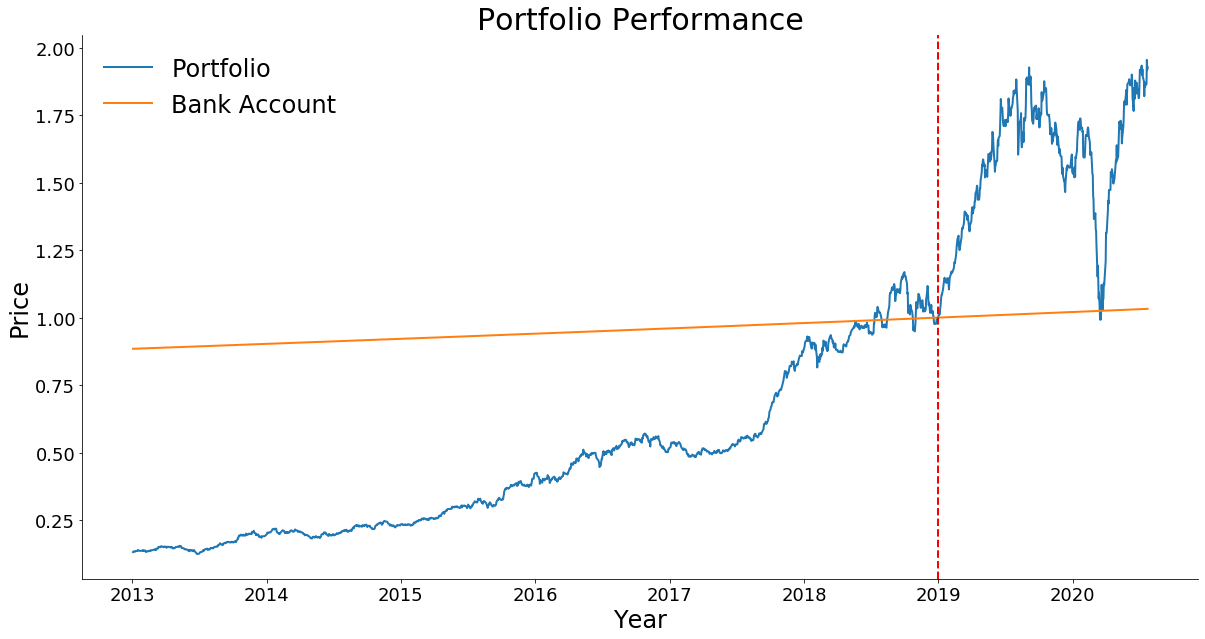

In [114]:
var, w = mean_variance_optimisation(train_returns, b_val=1.0)
portfolio = run_portfolio(w, base_index)
performance = float(pd.DataFrame(portfolio[base_index:]).pct_change().dropna().mean()) * TRADING_DAYS
print(f'Portfolio performance = {round(100*performance, 2)}% Rate of Return')

# Compare to bank
INTEREST_RATE = 0.02
risk_free = np.ones(len(daily))
for i in range(1, len(risk_free)):
    risk_free[i] = risk_free[i-1] * (1 + INTEREST_RATE/TRADING_DAYS)
risk_free /= risk_free[base_index]

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(daily.index, portfolio, label='Portfolio', lw=LW)
ax.plot(daily.index, risk_free, label='Bank Account', lw=LW)
ax.axvline(x='2019-01-01', c='red', linestyle='--', lw=LW)

sns.despine()
ax.set_title('Portfolio Performance', fontsize=LARGE)
ax.set_xlabel('Year', fontsize=MED)
ax.set_ylabel('Price', fontsize=MED)
plt.legend(frameon=False, fontsize=MED)
plt.show()

The above graph shows our portfolio's performance against a generous savings account (annual interest of 2%). Note that the optimisation algorithm only had access to data on the left of the red line, meaning that if we ran this algorithm with all the information that we had at the beginning of 2019, we would have made a 47% annual gain despite the COVID-19 related drop.

But the question is, what value of $b$ should we use? I arbitrarily used $b=0.1$ above corresponding to an expected rate of return of $10\%$. But what happens when we vary that? Additionally, how much historical data should we be using? Does adding too many years start adding irrelevant information?

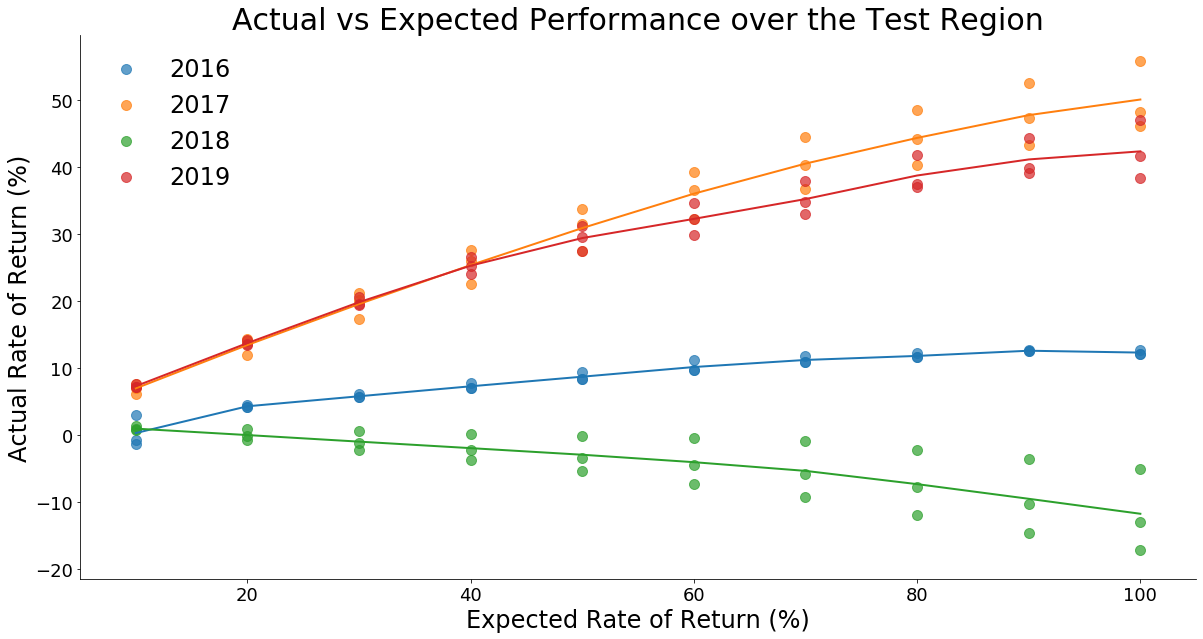

In [115]:
performances = {'b_val': [], 'year': [], 'period': [], 'performance': []}
# Try combination of b and years_back
for b_val in np.arange(0.1, 1.1, 0.1):
    for end in range(2016, 2020):
        for period in range(1, 4):
            tmp_train_returns = daily[(daily.index.year >= end - period - 1) & (daily.index.year < end)].pct_change().dropna()
            tmp_test_returns  = daily[daily.index.year == end].pct_change().dropna()
            
            var, w = mean_variance_optimisation(tmp_train_returns, b_val)
            portfolio = run_portfolio(w, returns=tmp_test_returns)
            performance = float(pd.DataFrame(portfolio).pct_change().dropna().mean()) * TRADING_DAYS
            
            performances['b_val'].append(100*b_val)
            performances['year'].append(end)
            performances['period'].append(period)
            performances['performance'].append(100*performance)
    
performances = pd.DataFrame(performances)

fig, ax = plt.subplots(figsize=(20, 10))
for year in performances.year.unique():
    ax.scatter(performances[performances.year == year].b_val, performances[performances.year == year].performance, 
               label=year, s=100, alpha=0.7)
    df = performances.groupby(['year', 'b_val']).mean().reset_index()
    ax.plot(df[df.year == year].b_val, df[df.year == year].performance, lw=LW)
    
ax.set_xlabel('Expected Rate of Return (%)', fontsize=MED)
ax.set_ylabel('Actual Rate of Return (%)', fontsize=MED)
ax.set_title('Actual vs Expected Performance over the Test Region', fontsize=LARGE)
plt.legend(frameon=False, fontsize=MED)
sns.despine()
plt.show()

This graph should give the reader some intuition for what value of expected rate of return they may wish to choose. It is a trade-off between possible high returns and uncertainty.

Each group of three dots in this graph corresponds to using either one, two or three years of historical data for asset allocation, with the performance of the allocation being measured during the subsequent year. For example, the three orange dots at the top right correspond to using data from either 2016, 2015-2016 and 2014-2016 in order to make asset allocation for 2017.

This graph demonstrates that the $b$ value that gave the best actual performance varies from year to year as is expected due to random variation in the stock market. It also shows that greater expected performance comes at the cost of greater volatility/risk.

Note also that the strategy is not flawless, and indeed there was a loss in 2018 for "greedier" expected returns.

In [116]:
lm=ols('performance ~ C(b_val) + C(period) + C(year)', data=performances).fit()
print(sm.stats.anova_lm(lm, typ=2))

                 sum_sq     df           F        PR(>F)
C(b_val)    4846.150957    9.0    8.888871  7.379543e-10
C(period)     85.629369    2.0    0.706781  4.955605e-01
C(year)    25960.049210    3.0  142.848740  6.381560e-37
Residual    6360.586172  105.0         NaN           NaN


The groups of three dots all appear to be fairly close in the above graph, and indeed an ANOVA test confirms that the length of historical data (either 1, 2 or 3 years into the past) has no statistically significant effect on the actual returns with $p=0.498$. This means that we can confidently use 3 years of historical data without worrying about adding noise to our dataset.

In [117]:
# Use only previous 3 years of data to reflect above findings
daily = pd.read_csv('daily.csv')

# Keep shares that have been around since the 2017
daily['date'] = pd.to_datetime(daily.date)
daily = daily[daily.date >= pd.to_datetime('2017-07-01')]
daily = daily.iloc[1:].ffill().dropna(axis=1).set_index('date')
# Remove JIN - lottery company
daily = daily.drop(['JIN', 'MGV'], axis=1)
# Calculate daily returns
returns = daily.pct_change().dropna()
# Remove assets that have an average zero/negative return
postive_return = returns.mean()[returns.mean() > 0].index.tolist()
returns = returns[postive_return]
daily = daily[postive_return]

# Split data into train and test (Not implying that there is machine learning, just want to avoid overfitting)
train_daily = daily[daily.index.year <= 2019]
test_daily  = daily[daily.index.year >  2019]
train_returns = train_daily.pct_change().dropna()

# Get the index where the test data starts
base_index = list(returns.index).index(returns[returns.index.year > 2019].index[0])

def run_portfolio(w, base_index=0, codes=daily.columns, returns=returns):
    ''' 
    Tests portfolio over all data
    
    INPUT:
        w          - Vector, representing portfolio's asset allocation 
        base_index - Scalar, index in portfolio that will be set to 1.0 as a reference point
    OUTPUT:
        portfolio - Vector, representing value of portfolio over time where it has a value 1.0 at the base_index
    '''
    portfolio = np.ones(len(returns)+1)
    total_returns = np.ones(len(codes))

    for i in range(1, len(portfolio)):
        total_returns *= 1 + returns[codes].to_numpy()[i-1]
        portfolio[i] = total_returns.T @ w
    portfolio /= portfolio[base_index]
    
    return portfolio

Based on our previous analysis of varying expected rates of return, I'm going to use a rate of 80% ($b = 0.8$), but feel free to use whatever value that you are comfortable with. Recall that higher expected returns will involve more risk.

In [118]:
b_val = 0.8

And lastly, there is one more problem before we start investing, and that is the cost of investing. Unfortunately we cannot add a constraint to our optimisation program to tell the algorithm that we want to limit the number of investments, as this is a NP-hard problem, meaning that it is computationally infeasible. However, we can run an approximate algorithm to get close to the true answer. Essentially, you set a maximum number of assets that you wish to invest in (e.g. 10), and the algorithm will trim away the least weighted assets in the optimal portfolio until only the maximum allowed number is reached.

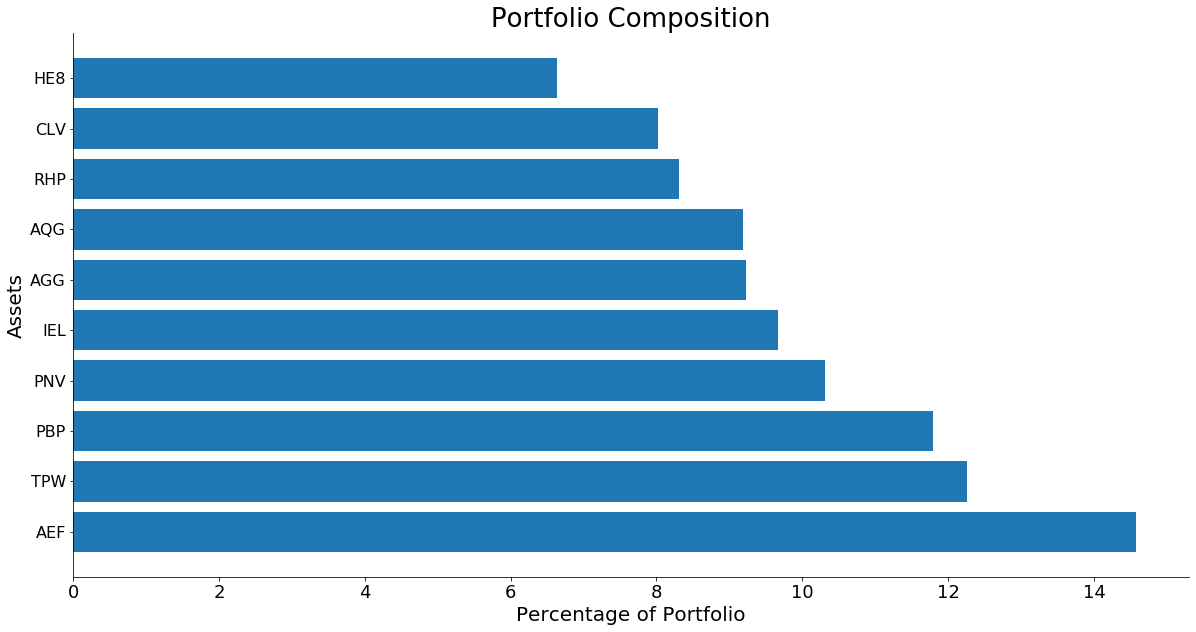

In [119]:
max_assets = 10
ret = train_returns.copy()
curr_size = len(ret.columns)

while curr_size > max_assets:
    var, w = mean_variance_optimisation(ret, b_val)
    # Get indexes of assets that were used in at least 0.1% of the portfolio
    indexes = [i for i in range(len(w)) if w[i] > 0.001]
    ret = ret.iloc[:, indexes]
    
    if len(ret.columns) == curr_size:
        # Remove smallest contributer
        ret = ret.drop(ret.columns[list(w).index(min(w))], axis=1)
        
    curr_size = len(ret.columns)
    
# Final optimisation with chosen assets
var, w = mean_variance_optimisation(ret, b_val)
composition = sorted(zip(w, ret.columns))

# Chart Portfolio Composition
fig, ax = plt.subplots(figsize=(20, 10))

assets = [e[1] for e in composition]
y_pos = np.arange(len(assets))
weights = [100*e[0] for e in composition]

ax.barh(y_pos, weights, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(assets, fontsize=16)
ax.invert_yaxis()
ax.set_xlabel('Percentage of Portfolio', fontsize=20)
ax.set_ylabel('Assets', fontsize=20)
ax.set_title('Portfolio Composition', fontsize=26)
sns.despine()
plt.show()

Now so far, we have still split up our data into "training" and "testing". We have only allowed our algorithm to see data up until the beginning of 2020, and now we can observe how it performs over the year:

The rate of return so far is 64.69%


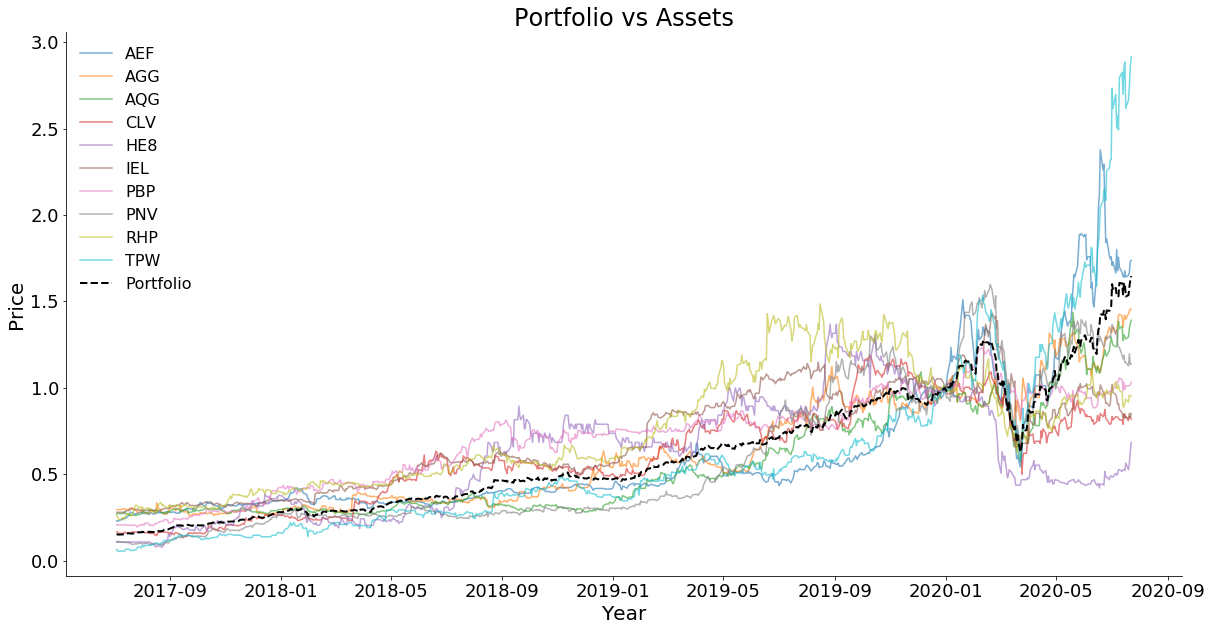

In [120]:
portfolio = run_portfolio(w, base_index, codes=ret.columns)
print(f'The rate of return so far is {round(100*(portfolio[-1] - 1), 2)}%')

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
for code in list(ret.columns):
    ax.plot(daily.index, daily[code]/daily[code].iloc[base_index], label=f'{code}', alpha=0.6)

ax.plot(daily.index, portfolio, label='Portfolio', lw=LW, c='black', linestyle='--')
sns.despine()
ax.set_title('Portfolio vs Assets', fontsize=24)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Price', fontsize=20)
plt.legend(frameon=False, fontsize=16)
plt.show()

Plotted are the 10 assets chosen by the algorithm, along with the portfolio that encapsulates them. I have normalised all of the asset values to be $1.0$ at the start of 2020, and you can see their relative adjusted close values from there. We can see that the rate of return that we would have recieved under this investment is 65% as is.

Now all that's left to do is run the numbers again using all of the data to receive the algorithm's recommendation for investing now.

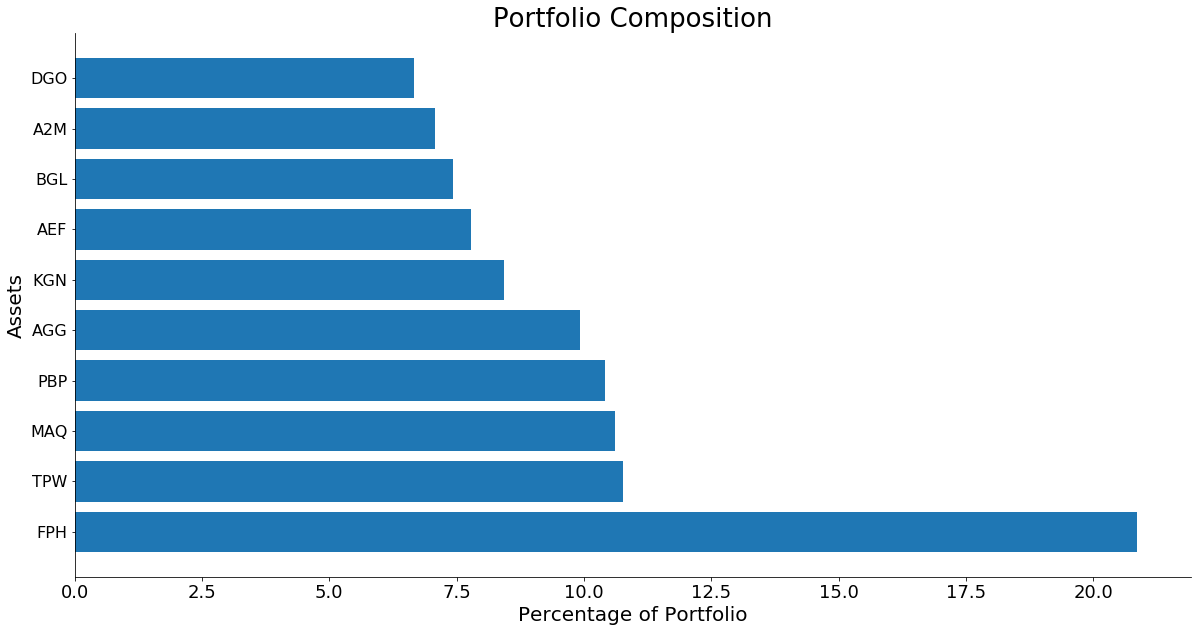

In [121]:
max_assets = 10
ret = returns.copy() # Using returns instead of train_returns here
curr_size = len(ret.columns)

while curr_size > max_assets:
    var, w = mean_variance_optimisation(ret, b_val)
    # Get indexes of assets that were used in at least 0.1% of the portfolio
    indexes = [i for i in range(len(w)) if w[i] > 0.001]
    ret = ret.iloc[:, indexes]
    
    if len(ret.columns) == curr_size:
        # Remove smallest contributer
        ret = ret.drop(ret.columns[list(w).index(min(w))], axis=1)
        
    curr_size = len(ret.columns)
    
# Final optimisation with chosen assets
var, w = mean_variance_optimisation(ret, b_val)
composition = sorted(zip(w, ret.columns))

# Chart Portfolio Composition
fig, ax = plt.subplots(figsize=(20, 10))

assets = [e[1] for e in composition]
y_pos = np.arange(len(assets))
weights = [100*e[0] for e in composition]

ax.barh(y_pos, weights, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(assets, fontsize=16)
ax.invert_yaxis()
ax.set_xlabel('Percentage of Portfolio', fontsize=20)
ax.set_ylabel('Assets', fontsize=20)
ax.set_title('Portfolio Composition', fontsize=26)
sns.despine()
plt.show()

And let's look at these assets' recent performance, normalised at today's date:

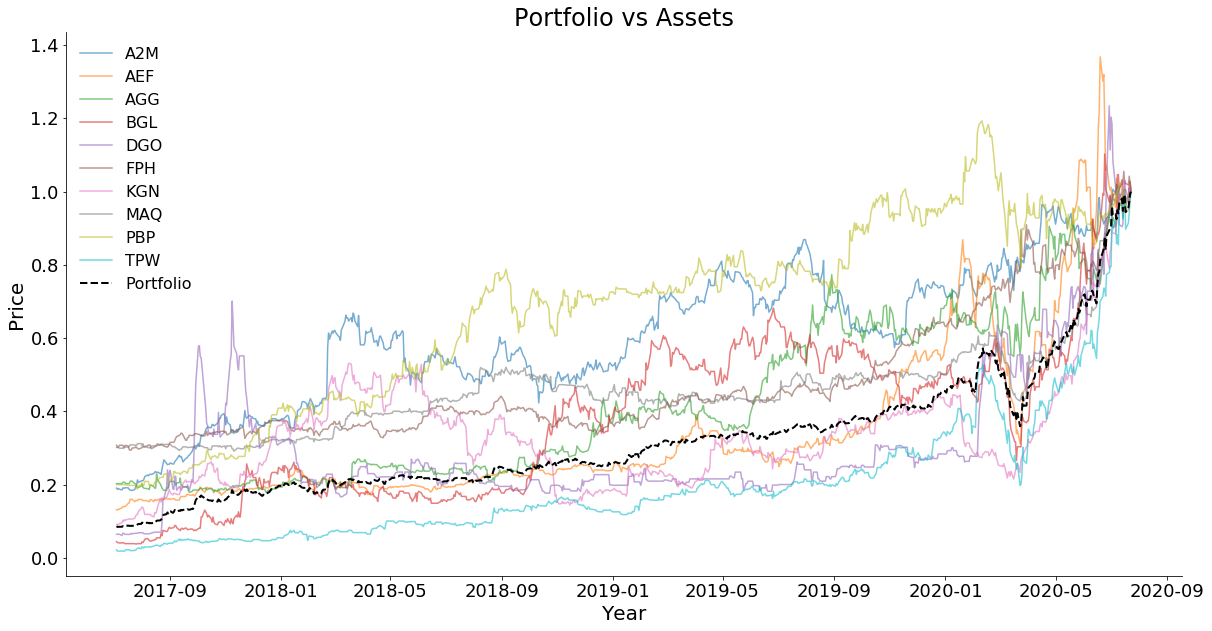

In [122]:
portfolio = run_portfolio(w, base_index=-1, codes=ret.columns)

# Plot
fig, ax = plt.subplots(figsize=(20, 10))
for code in list(ret.columns):
    ax.plot(daily.index, daily[code]/daily[code].iloc[-1], label=f'{code}', alpha=0.6)

ax.plot(daily.index, portfolio, label='Portfolio', lw=LW, c='black', linestyle='--')
sns.despine()
ax.set_title('Portfolio vs Assets', fontsize=24)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Price', fontsize=20)
plt.legend(frameon=False, fontsize=16)
plt.show()

Lastly, and just for fun. Let's see how random portfolios go from the start of 2020 to now

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:58<00:00,  2.38s/it]


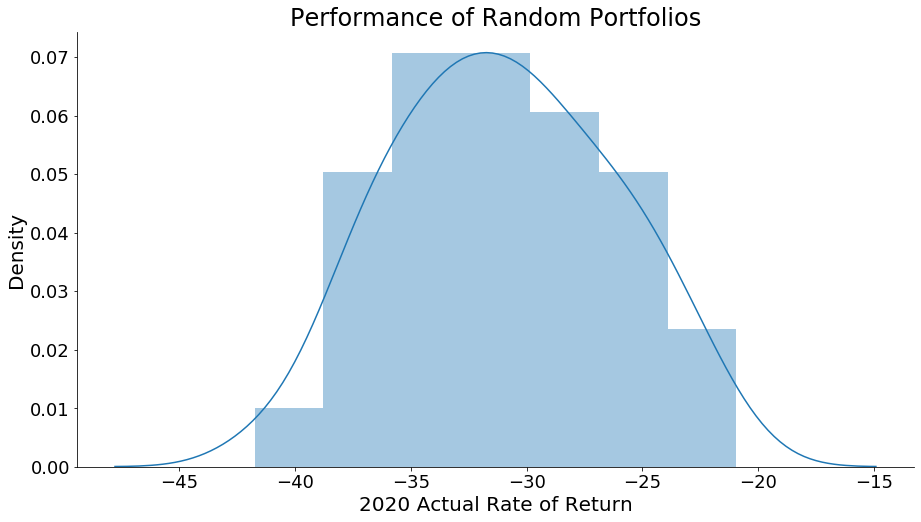

In [123]:
trials = 100
performances = []

for _ in tqdm(range(trials)):
    rand_w = np.random.randn(len(daily.columns))
    rand_w = (rand_w - min(rand_w))
    rand_w = rand_w/rand_w.sum()
    rand_w.sum()
    
    portfolio = run_portfolio(rand_w, base_index)
    performance = float(pd.DataFrame(portfolio[base_index:]).pct_change().dropna().mean()) * TRADING_DAYS
    performances.append(100 * (performance-1))

fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(performances, ax=ax)
sns.despine()
ax.set_title('Performance of Random Portfolios', fontsize=24)
ax.set_xlabel('2020 Actual Rate of Return', fontsize=20)
ax.set_ylabel('Density', fontsize=20)
plt.show()

We conclude with this graph, demonstrating that monkeys throwing darts results in annual losses of 20%-40%. It turns out that a little optimisation theory can indeed beat not only randomness, but also the market index.